In [1]:
import os
import json
from dataclasses import dataclass
from typing import Dict, List, Any, Tuple

import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight

import av  # pip install av
from transformers import (
    AutoImageProcessor,
    VideoMAEForVideoClassification,
    TrainingArguments,
    Trainer,
)

import evaluate  # pip install evaluate

# load environment variables with dotenv
from dotenv import load_dotenv
load_dotenv()


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
from train import *
import os


In [3]:
# Point this at the Olympic Boxing dataset directory

# Pretrained VideoMAE base (self-supervised on K400)
model_name = "MCG-NJU/videomae-base"

image_processor = AutoImageProcessor.from_pretrained(model_name)
model = VideoMAEForVideoClassification.from_pretrained(
    model_name,
    num_labels=len(LABEL2ID),
    label2id=LABEL2ID,
    id2label=ID2LABEL,
)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# check for cuda
if torch.cuda.is_available():
    model.to("cuda")
    print("Using CUDA")
else:
    print("Using CPU")

Using CUDA


In [5]:
from sklearn.model_selection import train_test_split
import re
from collections import Counter

def split_data():
    train_paths = []
    val_paths = []
    test_paths = []

    # Collect all paths with their labels and sources
    all_paths = []
    all_labels = []
    all_sources = []

    for label in os.listdir("preprocessed_clips_2"):
        paths = [f"preprocessed_clips_2/{label}/{p}" for p in os.listdir(f"preprocessed_clips_2/{label}")]
        
        for path in paths:
            # Extract source from filename: pattern is clip_task_[kamx_nums]_index_c.npy
            # Source is the part matching task_[kamx_nums]_index_c (everything from task_ to .npy)
            filename = os.path.basename(path)
            # Match task_ followed by any characters until .npy
            source_match = re.search(r'task_kam\d+_[^_]+', filename)
            if source_match:
                source = source_match.group(0)
            else:
                # Fallback: use filename without extension as source
                source = os.path.splitext(filename)[0]
            
            all_paths.append(path)
            all_labels.append(label)
            all_sources.append(source)

    # Create combined stratification key: label_source
    # This ensures both label and source distributions are maintained
    stratify_key = [f"{label}_{source}" for label, source in zip(all_labels, all_sources)]


    # First split: 80% train, 20% temp (which will become val+test)
    train_paths, temp_paths, train_labels, temp_labels, train_sources, temp_sources = train_test_split(
        all_paths, all_labels, all_sources,
        test_size=0.2,
        stratify=stratify_key,
        random_state=632
    )

    # Second split: split temp into 50% val, 50% test (which gives 10% val, 10% test overall)
    # Create new stratification key for temp split
    temp_stratify_key = [f"{label}_{source}" for label, source in zip(temp_labels, temp_sources)]

    temp_counts = Counter(temp_stratify_key)
    min_count = min(temp_counts.values())

    if min_count >= 2:
        val_paths, test_paths, val_labels, test_labels, val_sources, test_sources = train_test_split(
            temp_paths, temp_labels, temp_sources,
            test_size=0.5,
            stratify=temp_stratify_key,
            random_state=42
        )
    else:
        # Fall back to non-stratified split if some classes have < 2 members
        val_paths, test_paths, val_labels, test_labels, val_sources, test_sources = train_test_split(
            temp_paths, temp_labels, temp_sources,
            test_size=0.5,
            stratify=None,
            random_state=632
        )

    # Convert to class variables
    train_paths = train_paths
    val_paths = val_paths
    test_paths = test_paths
    
    return train_paths, val_paths, test_paths


In [6]:
from train import *
import random
class BoxingDataset(Dataset):
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    
    all_splits = split_data()
    train_paths = all_splits[0]
    val_paths = all_splits[1]
    test_paths = all_splits[2]

        
        
    def __init__(self, split: str):
        self.split = split
        
        
    def __len__(self):
        if self.split == "train":
            return len(self.train_paths)
        elif self.split == "val":
            return len(self.val_paths)
        elif self.split == "test":
            return len(self.test_paths)
        else:
            raise ValueError(f"Unknown split: {self.split}")

    def __getitem__(self, idx):
        if self.split == "train":
            path = self.train_paths[idx]
        elif self.split == "val":
            path = self.val_paths[idx]
        elif self.split == "test":
            path = self.test_paths[idx]
        else:
            raise ValueError(f"Unknown split: {self.split}")
        
        clip = np.load(path)
        
        # convert to float and scale to 0-1
        clip = clip.astype(np.float32) / 255.0
        
        # image net mean/std
        clip = (clip - self.mean) / self.std
        
        #reorder to (T,C,H,W)
        clip = clip.transpose(0,3,1,2)
        
        #convert to tensor
        clip = torch.from_numpy(clip)
        
        return {
            "pixel_values": clip,
            "labels": torch.tensor(LABEL2ID[path.split("/")[-2]], dtype=torch.long) 
        }



In [7]:
train_dataset = BoxingDataset(
    split="train",
)
val_dataset = BoxingDataset(
    split="val",
)
test_dataset = BoxingDataset(
    split="test",
)

In [8]:

# FACTS used batch_size=4, grad_accum=2, warmup_ratio=0.1, epochs=10
# Learning rate is not rendered in the HTML; start with 1e-4 and tune around it.
training_args = TrainingArguments(
    output_dir="./facts-boxing-videomae",
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    logging_steps=100,
    save_total_limit=2,
    num_train_epochs=10,
    per_device_train_batch_size=4, 
    per_device_eval_batch_size=8, 
    gradient_accumulation_steps=2,  # effective batch size 8
    warmup_ratio=0.1,
    learning_rate=1e-4,
    weight_decay=0.05,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="wandb",  # or "wandb"/"tensorboard"
    dataloader_num_workers=4,        # ADD THIS - use multiple workers
    dataloader_pin_memory=True,      # ADD THIS - faster CPU->GPU transfer
    dataloader_prefetch_factor=2, 
)

data_collator = VideoDataCollator()

train_labels = [LABEL2ID[path.split("/")[-2]] for path in BoxingDataset.train_paths]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(LABEL2ID)),
    y=np.array(train_labels)  # Ensure it's a numpy array
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)


In [9]:
sample_weights = [class_weights[label] for label in train_labels]
sampler = torch.utils.data.WeightedRandomSampler(
    sample_weights,                                              
    len(sample_weights), 
    replacement=True
)
sampler


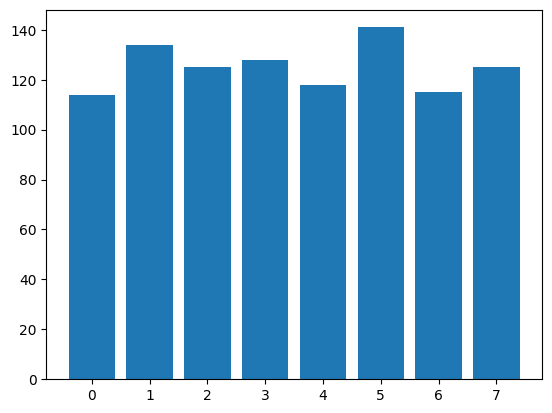

In [10]:
import random
import matplotlib.pyplot as plt
from collections import defaultdict

sample_counts = defaultdict(int)
for i in range(1000):
    sampled_idx = random.choices(train_labels, weights=sample_weights, k=1)[0]
    sample_counts[sampled_idx] += 1

# use matplotlib to plot the distribution

plt.bar(sample_counts.keys(), sample_counts.values())
plt.show()

In [11]:
class BalancedSamplerTrainer(Trainer):
    def __init__(self, *args, train_sampler=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_sampler = train_sampler
        
    def _get_train_sampler(self, train_dataset: Dataset | None = None):
        if train_dataset is None:
            train_dataset = self.train_dataset
            
        if train_dataset is None or not has_length(train_dataset):
            return None
        
        if self.train_sampler is not None:
            return self.train_sampler
        
        return super()._get_train_sampler(train_dataset)

trainer = BalancedSamplerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_sampler=sampler,
)


In [12]:
os.environ["WANDB_NAME"] = "New Preprocessing - 10 Epochs - Balanced Sampler - Stratified Spli"

# Train
trainer.train()


wandb: Currently logged in as: nkosik11 (nkosik11-hobby) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Macro F1,F1 Lhhp,Precision Lhhp,Recall Lhhp,F1 Rhhp,Precision Rhhp,Recall Rhhp,F1 Lhmp,Precision Lhmp,Recall Lhmp,F1 Rhmp,Precision Rhmp,Recall Rhmp,F1 Lhblp,Precision Lhblp,Recall Lhblp,F1 Rhblp,Precision Rhblp,Recall Rhblp,F1 Lhbp,Precision Lhbp,Recall Lhbp,F1 Rhbp,Precision Rhbp,Recall Rhbp
500,2.087400,2.265733,0.069799,0.065898,0.000000,0.000000,0.000000,0.109890,0.208333,0.074627,0.111888,0.444444,0.064000,0.000000,0.000000,0.000000,0.150538,0.205882,0.118644,0.072607,0.039855,0.407407,0.082262,0.045070,0.470588,0.000000,0.000000,0.000000
1000,2.033000,2.101100,0.068456,0.073978,0.014388,1.000000,0.007246,0.040268,0.200000,0.022388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136364,0.206897,0.101695,0.123223,0.070652,0.481481,0.085271,0.045643,0.647059,0.192308,0.166667,0.227273
1500,2.033200,2.222495,0.131544,0.108244,0.000000,0.000000,0.000000,0.028986,0.500000,0.014925,0.247379,0.167614,0.472000,0.000000,0.000000,0.000000,0.222222,0.208955,0.237288,0.112821,0.065476,0.407407,0.121212,0.076336,0.294118,0.133333,0.250000,0.090909
2000,1.964000,2.044230,0.131544,0.145899,0.034965,0.500000,0.018116,0.056338,0.500000,0.029851,0.245455,0.284211,0.216000,0.146789,0.195122,0.117647,0.217822,0.261905,0.186441,0.149425,0.088435,0.481481,0.116402,0.063953,0.647059,0.200000,0.137931,0.363636
2500,1.797600,1.998892,0.159732,0.155565,0.129630,0.437500,0.076087,0.057803,0.128205,0.037313,0.235294,0.207317,0.272000,0.115702,0.132075,0.102941,0.200000,0.145038,0.322034,0.167939,0.105769,0.407407,0.119403,0.080000,0.235294,0.218750,0.132075,0.636364
3000,1.485400,1.786829,0.222819,0.214087,0.048110,0.466667,0.025362,0.326316,0.252033,0.462687,0.264550,0.197628,0.400000,0.047059,0.117647,0.029412,0.293706,0.250000,0.355932,0.183908,0.133333,0.296296,0.224719,0.181818,0.294118,0.324324,0.400000,0.272727
3500,1.129600,1.720300,0.303356,0.311600,0.307692,0.457143,0.231884,0.256198,0.287037,0.231343,0.296774,0.248649,0.368000,0.373626,0.298246,0.500000,0.274725,0.203252,0.423729,0.413793,0.387097,0.444444,0.262295,0.296296,0.235294,0.307692,0.352941,0.272727
4000,0.922200,1.801469,0.284564,0.321908,0.153392,0.412698,0.094203,0.270270,0.246914,0.298507,0.343042,0.288043,0.424000,0.309091,0.223684,0.500000,0.337500,0.267327,0.457627,0.333333,0.380952,0.296296,0.389610,0.348837,0.441176,0.439024,0.473684,0.409091
4500,0.702300,1.713678,0.362416,0.361122,0.323383,0.515873,0.235507,0.354610,0.337838,0.373134,0.384384,0.307692,0.512000,0.376147,0.273333,0.602941,0.447761,0.400000,0.508475,0.307692,0.500000,0.222222,0.320000,0.500000,0.235294,0.375000,0.600000,0.272727
5000,0.549900,1.650539,0.445638,0.407964,0.530756,0.515358,0.547101,0.400000,0.330097,0.507463,0.328358,0.434211,0.264000,0.370968,0.410714,0.338235,0.525424,0.525424,0.525424,0.434783,0.526316,0.370370,0.379310,0.458333,0.323529,0.294118,0.416667,0.227273


TrainOutput(global_step=7450, training_loss=1.1350535305714446, metrics={'train_runtime': 901.1522, 'train_samples_per_second': 66.126, 'train_steps_per_second': 8.267, 'total_flos': 7.425696207814263e+19, 'train_loss': 1.1350535305714446, 'epoch': 10.0})

In [14]:

# Evaluate on test split
test_metrics = trainer.evaluate(test_dataset)
print("Test metrics:", test_metrics)


Test metrics: {'eval_loss': 2.058974266052246, 'eval_accuracy': 0.48053691275167787, 'eval_macro_f1': 0.45521439683261034, 'eval_f1_LHHP': 0.5545927209705372, 'eval_precision_LHHP': 0.4878048780487805, 'eval_recall_LHHP': 0.642570281124498, 'eval_f1_RHHP': 0.47096774193548385, 'eval_precision_RHHP': 0.41714285714285715, 'eval_recall_RHHP': 0.5407407407407407, 'eval_f1_LHMP': 0.26881720430107525, 'eval_precision_LHMP': 0.3968253968253968, 'eval_recall_LHMP': 0.2032520325203252, 'eval_f1_RHMP': 0.46511627906976744, 'eval_precision_RHMP': 0.47058823529411764, 'eval_recall_RHMP': 0.45977011494252873, 'eval_f1_LHBlP': 0.5384615384615384, 'eval_precision_LHBlP': 0.6511627906976745, 'eval_recall_LHBlP': 0.45901639344262296, 'eval_f1_RHBlP': 0.68, 'eval_precision_RHBlP': 0.85, 'eval_recall_RHBlP': 0.5666666666666667, 'eval_f1_LHBP': 0.37209302325581395, 'eval_precision_LHBP': 0.42105263157894735, 'eval_recall_LHBP': 0.3333333333333333, 'eval_f1_RHBP': 0.2916666666666667, 'eval_precision_RHBP':